In [1]:
import neurokit2 as nk
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.patches import Ellipse
from sklearn.preprocessing import MinMaxScaler
import seaborn as sns
from scipy.signal import find_peaks
from scipy import signal
from scipy.integrate import trapz
from scipy.interpolate import interp1d
import seaborn as sns
import heartpy as hp
import os
import pickle
import warnings
warnings.simplefilter('ignore', np.RankWarning)

In [2]:
def plt_performance(history, path='./', filename=''):
    epoch = list(range(0,len(history.history['loss'])))
    
    fig, (his_accuracy, his_loss) = plt.subplots(nrows=2,ncols=1,figsize=(10,8),sharex=True)
    his_loss.plot(epoch, history.history['loss'], label='Training loss')
    his_loss.plot(epoch, history.history['val_loss'], label='Validation loss')
    his_loss.set_xlabel("Epochs", fontsize=14)
    his_loss.set_ylabel("Loss", fontsize=14)
    his_loss.set_title("Loss", fontsize=14)
    his_loss.legend(loc='best')
    
    his_accuracy.plot(epoch, history.history['acc'], label='Training accuracy')
    his_accuracy.plot(epoch, history.history['val_acc'], label='Validation accuracy')
    his_accuracy.set_xlabel("Epochs", fontsize=14)
    his_accuracy.set_ylabel("Accuracy", fontsize=14)
    his_accuracy.set_title("Accuracy", fontsize=14)
    his_accuracy.legend(loc='best')
    
    fig.tight_layout()
    if filename == '':
        plt.savefig(f'{path}/performance.png', bbox_inches='tight')
    else:
        plt.savefig(f'{path}/{filename}.png', bbox_inches='tight')
        
# def preprocessing(PPG_data):
#     index = 0
#     x = list(range(0,len(PPG_data[0])))
#     for PPG in PPG_data:
#         poly = np.polyfit(x, PPG, deg=50)
#         polied = np.polyval(poly, x)
#         detrended = PPG - polied
#         PPG_data[index] = detrended
#         index += 1
        
#     return PPG_data

def preprocessing(ppg_data, view = False, participant = ''):
    # moving average function
    m_avg = lambda t, x, w : (np.asarray([t[i] for i in range(w, len(x) - w)]),
                          np.convolve(x, np.ones((2*w + 1, )) / (2*w + 1),
                                      mode = 'valid'))

    fs = len(ppg_data)/(60)  # sample rate

    # moving average
    w_size = int(fs*.5)  # width of moving window
    times = list(range(0,len(ppg_data)))
    mt, ms = m_avg(times, ppg_data, w_size)

    sign = (ppg_data[w_size:-w_size]-ms)

    analytical_signal = np.abs(signal.hilbert(sign))

    fs = len(sign) / (max(mt) - min(mt))
    w_size = int(fs)
    mt_new, mov_avg = m_avg(mt, analytical_signal, w_size)

    signal_pure = sign[w_size : -w_size] / mov_avg
    
    if view:
        plt.ioff()
        
        fig, (ax1, ax2, ax3) = plt.subplots(nrows = 3, ncols = 1, figsize = (10, 8), sharex=True)
        ax1.plot(times, ppg_data, "b-", label="Original")
        ax1.legend(loc='best')
        ax1.set_title("participants"+str(participant)+" Raw", fontsize=14)#, fontweight="bold")

        ax2.plot(mt, sign, 'r-', label="Pure signal")
        ax2.plot(mt_new, mov_avg, 'b-', label='Modulation', alpha=.5)
        ax2.legend(loc='best')
        ax2.set_title("Raw -> filtered", fontsize=14)#, fontweight="bold")

        ax3.plot(mt_new, signal_pure, "g-", label="Demodulated")
        ax3.set_xlim(0, mt[-1])
        ax3.set_title("Raw -> filtered -> demodulated", fontsize=14)#, fontweight="bold")

        ax3.set_xlabel("Time (sec)", fontsize=14) # common axis label
        ax3.legend(loc='best')

        fig.tight_layout()
        plt.savefig(f'./plot_img/{participant}.png', bbox_inches='tight')
        
    return signal_pure

def get_peaks(ppg_processed):
    diff_sig_2 = np.diff(ppg_processed) ## do
    peaks_2, _ = find_peaks(diff_sig_2, distance=100*(30/60), prominence=0.01)
    result = []
    peaks = []
    for i in range(len(peaks_2)):
        if diff_sig_2[peaks_2][i] > 40:
            result.append(peaks_2[i])
            peaks.append(diff_sig_2[peaks_2][i])
            
    return result, peaks, diff_sig_2

In [3]:
dir_list_ = os.listdir("./data")
dir_list_.sort()
count = 0
dir_list = []
for i in range(22):
    dir_list.append(dir_list_[i])
    
#### pop unavailable data
dir_list.pop(5)
dir_list.pop(2)

print(dir_list)
df_PPG = pd.DataFrame(columns=['participant','video_number','ppg','valence','arousal'])
Valence_data = []
Arousal_data = []
PPG_data = []

file_num = 0
for file in dir_list:
    dat_file = f'./data/{file}'
    with open(dat_file, 'rb') as f:
        Channel_data = pickle.load(f,encoding='latin1')
    data = Channel_data["data"]
    labels = Channel_data["labels"]
    for video_num in range(40):
        dataP = data[video_num,38]
        dataP = dataP[384:]
        
        label = labels[video_num]
        if label[0] < 5:
            Valence = 0
        if label[0] >= 5:
            Valence = 1
        if label[1] < 5:
            Arousal = 0
        if label[1] >= 5:
            Arousal = 1
        instance = [(file_num, video_num, dataP, Valence, Arousal)]
        new_instance = pd.DataFrame(instance, columns=['participant','video_number','ppg','valence','arousal'])
        df_PPG = pd.concat([df_PPG, new_instance], ignore_index = True)
        PPG_data.append(dataP)
        Valence_data.append(Valence)
        Arousal_data.append(Arousal)
    file_num += 1
    
PPG_shape = np.array(PPG_data)
PPG_shape.shape

['s01.dat', 's02.dat', 's04.dat', 's05.dat', 's07.dat', 's08.dat', 's09.dat', 's10.dat', 's11.dat', 's12.dat', 's13.dat', 's14.dat', 's15.dat', 's16.dat', 's17.dat', 's18.dat', 's19.dat', 's20.dat', 's21.dat', 's22.dat']


(800, 7680)

In [4]:
preprocessed = []

for PPG in PPG_data:
    preprocessed_d = preprocessing(PPG,view=False)
    preprocessed.append(preprocessed_d)

In [5]:
# Concatenate PPG data of each person to use min-max normalization method 
i = 1
new_PPG = []
tmp_PPG = np.empty(0)
for PPG in preprocessed:
    if i % 40 != 0:
        tmp_PPG = np.concatenate([tmp_PPG, PPG])
    else:
        tmp_PPG = np.concatenate([tmp_PPG, PPG])
        new_PPG.append(tmp_PPG)
        tmp_PPG = np.empty(0)
    i += 1
    
    
# Normalize personal PPG data and Split into per video
new_PPG = np.array(new_PPG)
new_PPG.shape[0]
new_PPG = new_PPG.reshape(new_PPG.shape[0],new_PPG.shape[1],1)

normalized = []

for PPG in new_PPG:
    # Normalized personal PPG
    scaler = MinMaxScaler()
    norm = scaler.fit_transform(PPG) * 1000
    # norm = scaler.fit_transform(PPG)
    
    # Split into per video
    for i in range(40):
        norm_video = norm[i*7680 : i*7680+7680]
        normalized.append(norm_video)

normalized = np.array(normalized)
normalized.shape

<ipython-input-5-e6cf46d087df>:33: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  normalized = np.array(normalized)


(800,)

In [6]:
import neurokit2.ppg.ppg_findpeaks as findpeaks

In [7]:
segmented = []
index = 0
cal= 0
valence_data = []
arousal_data = []

for PPG in normalized:
    
    result = findpeaks(preprocessed[index], sampling_rate=128)
    a = result['PPG_Peaks']
    
    for idx in a:
        a = idx
        if a > 70:
            seg = PPG[a-70:a+70]
            times = list(range(0,len(seg)))
        else:
            seg = PPG[0:a+70]
            times = list(range(0,len(seg)))
        if len(seg) == 140:
            cal+=1
            segmented.append(seg)
            valence_data.append(Valence_data[index])
            arousal_data.append(Arousal_data[index])

    index += 1

In [8]:
print(len(segmented[0]))
print(len(valence_data))

140
52613


In [9]:
train_x = segmented
train_valence = valence_data
train_arousal = arousal_data
print(f"x_data length : {len(train_valence)},", f"y_data length : {len(arousal_data)}")

x_data length : 52613, y_data length : 52613


In [10]:
x_train_data = np.array(train_x).astype(np.float64)
y_train_data = np.array(train_valence).astype(np.float64)
print(x_train_data.shape, y_train_data.shape)

X_train = x_train_data.reshape((x_train_data.shape[0], x_train_data.shape[1], 1))
Y_train = y_train_data.reshape((y_train_data.shape[0],1))

print(f"X_train shape : {X_train.shape}, Y_train shape : {Y_train.shape}")

(52613, 140, 1) (52613,)
X_train shape : (52613, 140, 1), Y_train shape : (52613, 1)


In [11]:
# Set Hyperparameters of the model
learning_rate = 0.0001
epochs = 150
batch_size=128

In [12]:
import tensorflow as tf
tf.config.experimental_run_functions_eagerly(True)
from tensorflow import keras
from tensorflow.keras import layers, callbacks
# from tensorflow.keras import Sequential
from tensorflow.keras.optimizers import RMSprop, Adam
from tensorflow.keras.layers import Dense, Flatten, Dropout,BatchNormalization, Conv1D,MaxPooling1D
from tensorflow.keras.models import Sequential
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

In [13]:
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
  # Restrict TensorFlow to only allocate 2 GB of memory on the first GPU
  try:
    tf.config.experimental.set_virtual_device_configuration(
        gpus[0],
        [tf.config.experimental.VirtualDeviceConfiguration(memory_limit=3000)]) # limit in megabytes
    logical_gpus = tf.config.experimental.list_logical_devices('GPU')
    print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
  except RuntimeError as e:
    # Virtual devices must be set before GPUs have been initialized
    print(e)

1 Physical GPUs, 1 Logical GPUs


In [14]:
from tensorflow.keras import optimizers
from tensorflow.keras.layers import Activation
import random
from tensorflow.keras.initializers import glorot_uniform
seed = 12345
np.random.seed(seed)
random.seed(seed)

In [15]:
def create_model2():
    model = Sequential()
    model.add(Conv1D(filters = 10, kernel_size = 2, strides = 1, input_shape = (140, 1), activation = 'relu'))
    model.add(BatchNormalization())
    model.add(MaxPooling1D(pool_size=2, strides=1, padding='valid'))#
    # model.add(BatchNormalization())
    model.add(Conv1D(filters = 20, kernel_size = 2, strides = 1, activation = 'relu'))
    model.add(BatchNormalization())
    model.add(MaxPooling1D(pool_size=2, strides=1, padding='valid'))#
    # model.add(BatchNormalization())
    model.add(Flatten())
    model.add(Dense(700))
    model.add(Dropout(0.3))
    model.add(Dense(600))
    model.add(Dropout(0.3))
    model.add(Dense(1, activation='sigmoid'))

    model.compile(loss='binary_crossentropy', optimizer=Adam(lr=learning_rate), metrics=['acc'])

    model.summary()
    return model
model2 = create_model2()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d (Conv1D)              (None, 139, 10)           30        
_________________________________________________________________
batch_normalization (BatchNo (None, 139, 10)           40        
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, 138, 10)           0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 137, 20)           420       
_________________________________________________________________
batch_normalization_1 (Batch (None, 137, 20)           80        
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 136, 20)           0         
_________________________________________________________________
flatten (Flatten)            (None, 2720)              0

In [16]:
history2 = model2.fit(X_train,
                  Y_train,
                  epochs=epochs,
                  batch_size=batch_size,
                  validation_split=0.2,
                  shuffle=True,
                  verbose=1)

Epoch 1/150
329/329 [==============================] - 10s 30ms/step - loss: 0.9139 - acc: 0.5126 - val_loss: 0.7420 - val_acc: 0.5295
Epoch 2/150
329/329 [==============================] - 10s 29ms/step - loss: 0.8329 - acc: 0.5119 - val_loss: 0.7545 - val_acc: 0.5026
Epoch 3/150
329/329 [==============================] - 10s 32ms/step - loss: 0.8241 - acc: 0.5127 - val_loss: 0.7342 - val_acc: 0.5275
Epoch 4/150
329/329 [==============================] - 9s 28ms/step - loss: 0.8084 - acc: 0.5148 - val_loss: 0.7317 - val_acc: 0.5164
Epoch 5/150
329/329 [==============================] - 9s 28ms/step - loss: 0.8012 - acc: 0.5140 - val_loss: 0.7444 - val_acc: 0.5222
Epoch 6/150
329/329 [==============================] - 9s 28ms/step - loss: 0.7935 - acc: 0.5138 - val_loss: 0.7250 - val_acc: 0.5285
Epoch 7/150
329/329 [==============================] - 9s 28ms/step - loss: 0.7903 - acc: 0.5161 - val_loss: 0.7319 - val_acc: 0.5014
Epoch 8/150
329/329 [==============================] - 9s 2

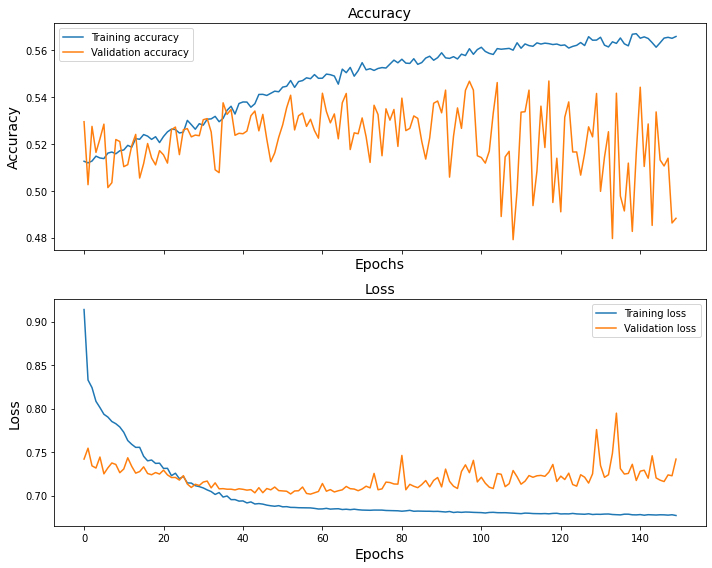

In [17]:
plt_performance(history2,path='./plot_performance',filename='1DCNN_normalize_0524(5)')

In [18]:
def create_model3():
    model = Sequential()
    model.add(Conv1D(16, 2, activation = 'relu', input_shape=(X_train.shape[1], X_train.shape[2]), kernel_initializer = glorot_uniform(seed = seed)))
    model.add(BatchNormalization()) 
    model.add(Conv1D(16, 2, activation = 'relu'))
    model.add(BatchNormalization()) 
    model.add(Flatten())
    model.add(Dropout(0.5))
    model.add(Dense(16, activation = 'relu', kernel_initializer = glorot_uniform(seed = seed)))
    model.add(BatchNormalization())
    model.add(Dropout(0.5))
    model.add(Dense(1, activation = 'sigmoid', kernel_initializer = glorot_uniform(seed = seed)))
    model.compile(loss = 'binary_crossentropy', optimizer = Adam(lr=0.0005), metrics = ['accuracy'])
    #print(model.summary())

    return model
model3 = create_model3()

In [19]:
history3 = model3.fit(X_train,
                  Y_train,
                  epochs=epochs,
                  batch_size=batch_size,
                  validation_split=0.2,
                  shuffle=True,
                  verbose=1)

Epoch 1/150
329/329 [==============================] - 10s 31ms/step - loss: 0.9082 - accuracy: 0.5085 - val_loss: 0.6943 - val_accuracy: 0.5245
Epoch 2/150
329/329 [==============================] - 10s 30ms/step - loss: 0.7934 - accuracy: 0.5098 - val_loss: 0.7000 - val_accuracy: 0.5125
Epoch 3/150
329/329 [==============================] - 10s 30ms/step - loss: 0.7412 - accuracy: 0.5170 - val_loss: 0.6940 - val_accuracy: 0.5230
Epoch 4/150
329/329 [==============================] - 10s 30ms/step - loss: 0.7137 - accuracy: 0.5212 - val_loss: 0.6912 - val_accuracy: 0.5365
Epoch 5/150
329/329 [==============================] - 10s 30ms/step - loss: 0.7003 - accuracy: 0.5254 - val_loss: 0.6924 - val_accuracy: 0.5160
Epoch 6/150
329/329 [==============================] - 10s 31ms/step - loss: 0.6936 - accuracy: 0.5328 - val_loss: 0.6933 - val_accuracy: 0.5104
Epoch 7/150
329/329 [==============================] - 10s 30ms/step - loss: 0.6898 - accuracy: 0.5385 - val_loss: 0.6902 - val_ac

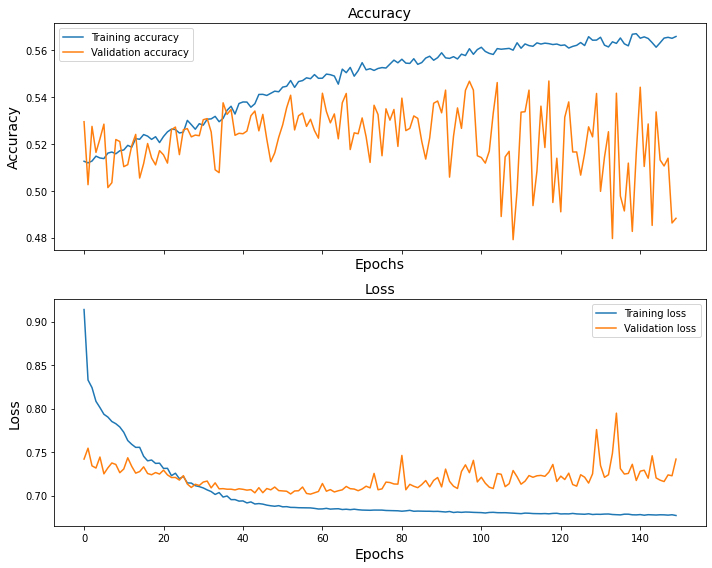

In [20]:
plt_performance(history2,path='./plot_performance',filename='1DCNN_normalize_0524(6)')

In [21]:
from tensorflow.keras.layers import LSTM, GRU


# one GRU layers with three dense layers-> IT WORKS !
model = Sequential()
model.add(GRU(units=128,
              dropout=0.25,
              recurrent_dropout=0.25,
              return_sequences=False,
              input_shape=(X_train.shape[1],X_train.shape[2])))
model.add(BatchNormalization())

# Dense net
model.add(Dense(512, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.3))
model.add(Dense(256, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.3))
model.add(Dense(128, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.3))
model.add(Dense(1, activation='sigmoid'))

callback_list = [tf.keras.callbacks.ModelCheckpoint(filepath='BinaryClassification_Dense3-callback.h5', monitor='val_accuracy', save_best_only=True),
                tf.keras.callbacks.EarlyStopping(patience=10)]

model.compile(loss='binary_crossentropy', optimizer=Adam(lr=learning_rate), metrics=['acc'])
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
gru (GRU)                    (None, 128)               50304     
_________________________________________________________________
batch_normalization_5 (Batch (None, 128)               512       
_________________________________________________________________
dense_5 (Dense)              (None, 512)               66048     
_________________________________________________________________
batch_normalization_6 (Batch (None, 512)               2048      
_________________________________________________________________
dropout_4 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_6 (Dense)              (None, 256)               131328    
_________________________________________________________________
batch_normalization_7 (Batch (None, 256)              